In [135]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rc("font", family="NanumGothic")

# 0. 데이터 확인

In [2]:
df_info = pd.read_csv('./open/data_info.csv')
df_sample_submission = pd.read_csv('./open/sample_submission.csv')
df_test = pd.read_csv('./open/test.csv')
df_train = pd.read_csv('./open/train.csv')
df_info.head()

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부


In [3]:
df_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [60]:
df_train = df_train.drop('id', axis=1) #id와 idx가 겹치므로 drop
df_test = df_test.drop('id',axis=1)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [66]:
df_train["base_date"] = pd.to_datetime(df_train["base_date"],format='%Y%m%d')
df_test["base_date"] = pd.to_datetime(df_test["base_date"],format='%Y%m%d')

In [69]:
df_train.describe().T.sort_values(by='std', ascending=False).style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
weight_restricted,4701217.000000,5618.742381,13953.433235,0.000000,0.000000,0.000000,0.000000,50000.000000
target,4701217.000000,42.788442,15.954434,1.000000,30.000000,43.000000,54.000000,113.000000
maximum_speed_limit,4701217.000000,61.253292,12.133539,30.000000,50.000000,60.000000,70.000000,80.000000
base_hour,4701217.000000,11.928196,6.722092,0.000000,6.000000,12.000000,18.000000,23.000000
connect_code,4701217.000000,0.266022,5.227760,0.000000,0.000000,0.000000,0.000000,103.000000
road_rating,4701217.000000,104.958500,1.840107,103.000000,103.000000,106.000000,107.000000,107.000000
road_type,4701217.000000,0.615224,1.211268,0.000000,0.000000,0.000000,0.000000,3.000000
lane_count,4701217.000000,1.836651,0.687751,1.000000,1.000000,2.000000,2.000000,3.000000
start_longitude,4701217.000000,126.521684,0.156366,126.182617,126.423200,126.511195,126.583975,126.930941
end_longitude,4701217.000000,126.521695,0.156352,126.182617,126.423200,126.511195,126.583975,126.930941


In [125]:
#multi_linked, vehicle_restricted, height_restricted의 표준편차가 매우작은것으로 보아 값이 별로 없을 수 있음
noVal = ['multi_linked', 'vehicle_restricted', 'height_restricted']
for col in (noVal):
    print(df_train[col].value_counts())
    print(df_test[col].value_counts())

0    4698978
1       2239
Name: multi_linked, dtype: int64
0    291241
Name: multi_linked, dtype: int64
0.0    4701217
Name: vehicle_restricted, dtype: int64
0.0    291241
Name: vehicle_restricted, dtype: int64
0.0    4701217
Name: height_restricted, dtype: int64
0.0    291241
Name: height_restricted, dtype: int64


In [127]:
print('multi_linked prop: {0:.4f}'.format(2239/4698978))

multi_linked prop: 0.0005


In [129]:
#셋 다 무의미하므로 drop
df_train = df_train.drop(noVal, axis=1)
df_test = df_test.drop(noVal, axis=1)

In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int64         
 3   lane_count             int64         
 4   road_rating            int64         
 5   road_name              object        
 6   connect_code           int64         
 7   maximum_speed_limit    float64       
 8   weight_restricted      float64       
 9   road_type              int64         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_latitude           float64       
 16  end_longitude          float64       
 17  end_turn_restricted    object        
 18  target                

# 1. NA확인

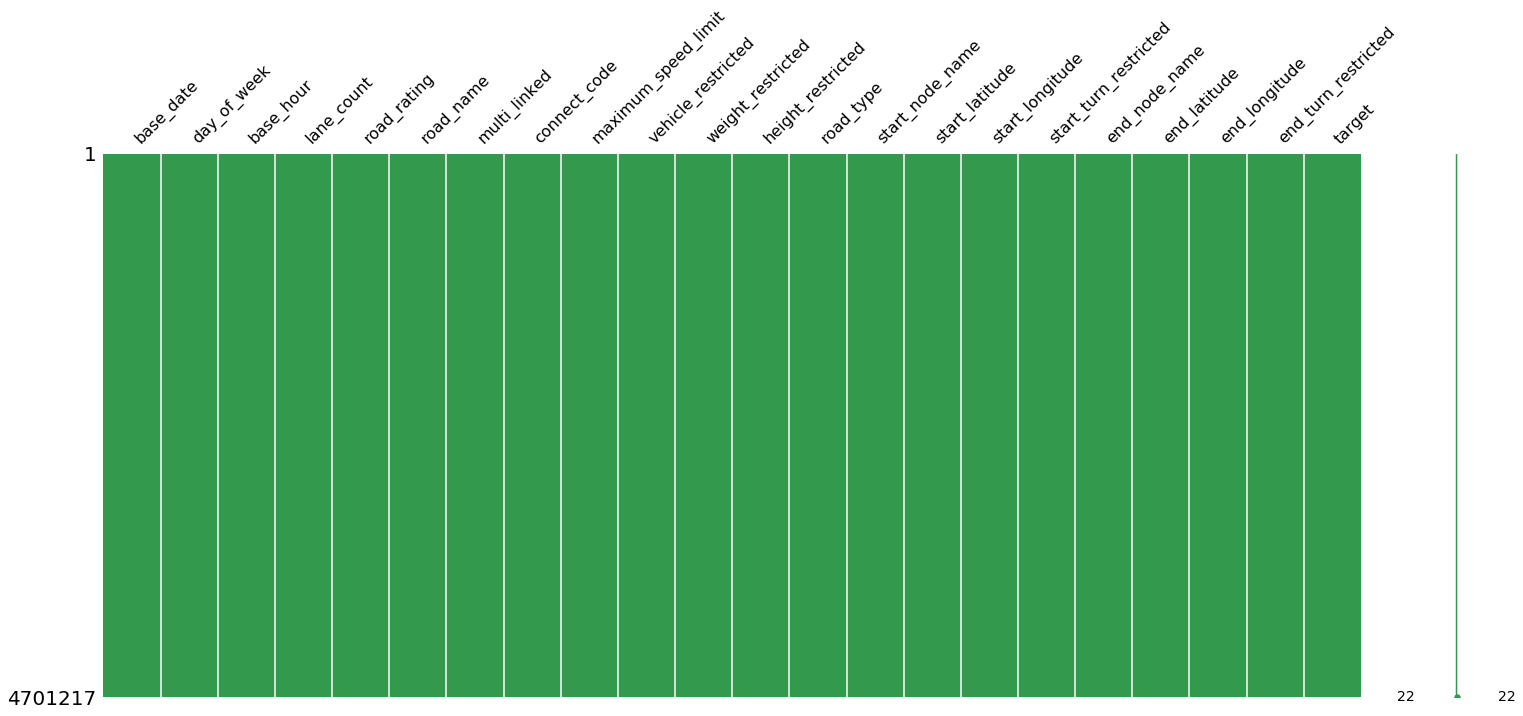

In [67]:
import missingno as msno
msno.matrix(df_train,color=(0.2,0.6,0.3))

# 2. 상관관계 분석

In [117]:
df_train.corr()['target'].sort_values(ascending=False)

target                 1.000000
maximum_speed_limit    0.425715
weight_restricted      0.294092
road_type              0.200840
connect_code           0.048348
start_latitude         0.036280
end_latitude           0.036139
end_longitude         -0.001000
start_longitude       -0.001168
multi_linked          -0.008408
lane_count            -0.144256
base_hour             -0.159407
road_rating           -0.261693
vehicle_restricted          NaN
height_restricted           NaN
Name: target, dtype: float64

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


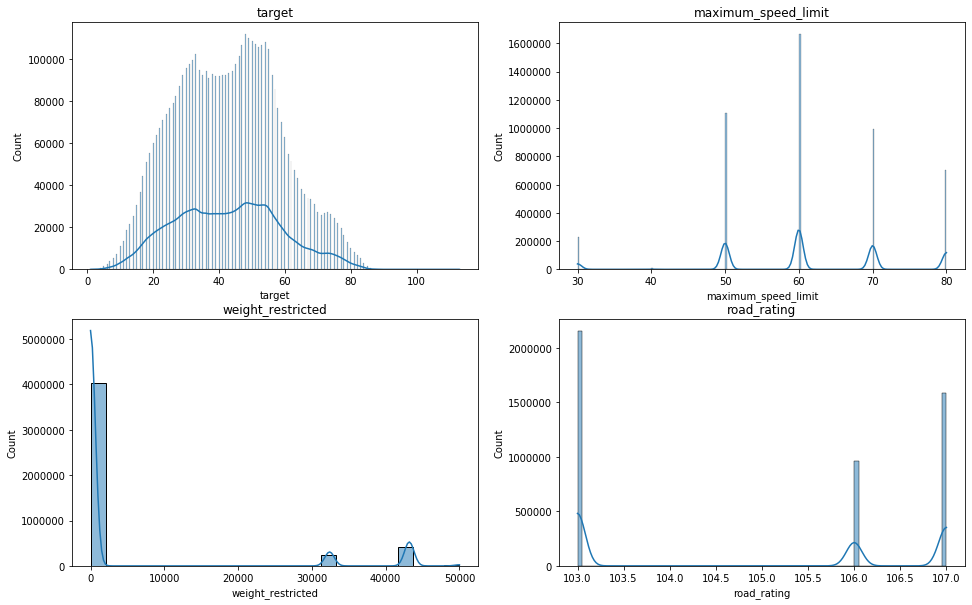

In [118]:
target_corr = abs(df_train.corr()['target']).sort_values(ascending=False)
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.histplot(df_train[target_corr.keys()[i]], kde=True)
    plt.title(target_corr.keys()[i])

1. maximum_speed_limit    0.425715
2. weight_restricted      0.294092
3. road_type              0.200840
4. connect_code           0.048348

등으로 부족한 특성 늘리기

# 3. 시공간 분석

## 3.1 시간

 1.   base_date              int64  
 2.   day_of_week            object 
 3.   base_hour              int64  

In [102]:
df_time = df_train[['base_date','day_of_week','base_hour','target']].copy()
df_time.head()

,base_date,day_of_week,base_hour,target
0,2022-06-23,목,17,52.0
1,2022-07-28,목,21,30.0
2,2021-10-10,일,7,61.0
3,2022-03-11,금,13,20.0
4,2021-10-05,화,8,38.0


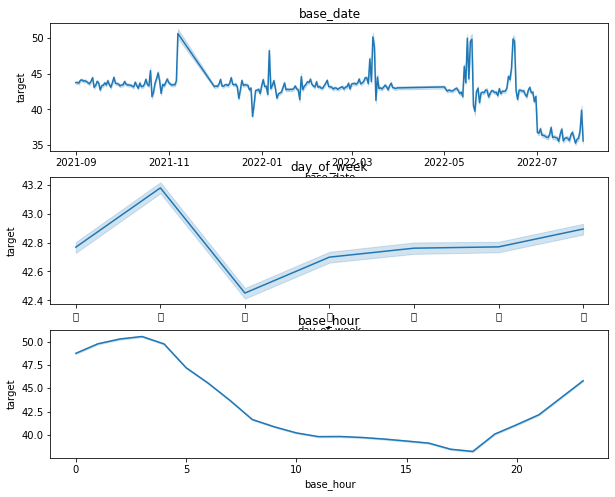

In [134]:
columns = np.array(df_time.columns)
plt.figure(figsize=(10,8))
for i in range(len(columns)-1):
    plt.subplot(3,1,i+1)
    sns.lineplot(x=df_time[columns[i]], y=df_time['target'])
    plt.title(columns[i])

## 3.2 공간

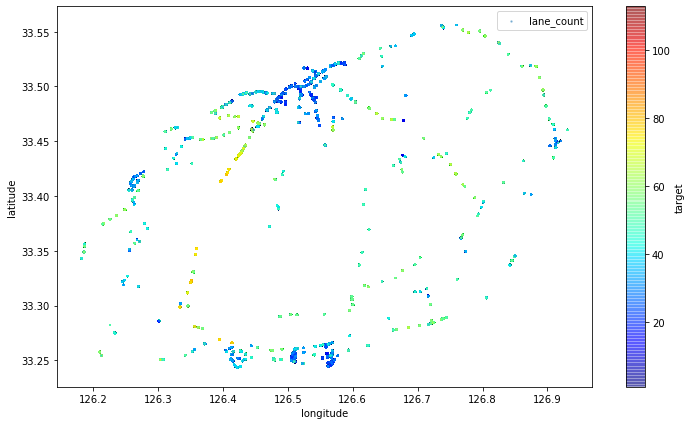

In [98]:
ax=df_train.plot(kind="scatter",x='start_longitude',y='start_latitude',alpha=.4,s=df_train['lane_count'],label='lane_count',
                figsize=(12,7),c='target',cmap=plt.get_cmap('jet'),colorbar=True,sharex=False)
ax.set(xlabel='longitude',ylabel='latitude')
plt.legend() #중부 산간 지방 또는 해안도로주변으로 갈수록 target이 커짐

# 4. 범주형 자료

In [77]:
df_train_categorical = df_train.select_dtypes('object').copy()
df_train_categorical.head()

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
0,목,지방도1112호선,제3교래교,없음,제3교래교,없음
1,목,일반국도11호선,광양사거리,있음,KAL사거리,없음
2,일,일반국도16호선,창고천교,없음,상창육교,없음
3,금,태평로,남양리조트,없음,서현주택,없음
4,화,일반국도12호선,애월샷시,없음,애월입구,없음


In [78]:
df_train_categorical['day_of_week'].value_counts()

금    684024
수    675583
목    674070
일    673632
토    669767
화    662498
월    661643
Name: day_of_week, dtype: int64

In [96]:
df_train_cateogorical['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

In [115]:
df_train_cateogorical[df_train_categorical['road_name']=='-']

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
6,목,-,가동,없음,나동,없음
14,목,-,송목교,없음,송목교,없음
28,일,-,광평교차로,없음,금악,없음
30,목,-,일호유리,없음,상귀교차로,없음
31,목,-,남수교,없음,남수교,없음
...,...,...,...,...,...,...
4701204,금,-,한남교차로,없음,서중2교,없음
4701205,수,-,감귤창고,없음,수협,없음
4701208,수,-,제2태흥교,없음,제2태흥교,없음
4701212,목,-,대림사거리,없음,금덕해운,없음


In [133]:
print('표기안된 도로 비율: {0:.4f}%'.format(569463/4701217)) # 12프로 어떻게 채울까요???

표기안된 도로 비율: 0.1211%


In [99]:
df_train_categorical['start_node_name'].unique() #end와 종류는 같음

array(['제3교래교', '광양사거리', '창고천교', '남양리조트', '애월샷시', '시청입구2', '가동', '외도천교',
       '신성교회', '양수장', '노루생이', '선경오피스텔', '명도암교차로', '서홍교', '송목교', '아라초등학교앞',
       '그랜드호텔사거', '중산간서로6091', '광령3교차로', '오조한도교입구', '종합운동장입구사거리',
       '동부장의운수사', '양천동', '한솔고기국수', '제5산록교', '강정교', '어시천교', '광평교차로',
       '버으내교차로', '일호유리', '남수교', '남읍학교살리기다가구', '거로마을', '서현주택', '명월교',
       '연동사거리', '제주일보사거리', '인다마을', '창성세차장', '오당빌레길1', '수복당', '해안동804-4',
       '노을과포도향기', '다이소제주화북점', '수장교', '동광램프(서귀포)', '경마장교', '난산사거리', '미수2교',
       '동중입구', '창천교', '수모루교차로', '성읍교차로', '오봉교', '아라주공아파트', '고성교차로',
       '서호2차현대맨션203동', '김약국', '국립제주박물관', '서귀포경찰서', '동홍사거리', '제2성읍교',
       '하귀입구', '서원', '동광2교차로', '진은교', '성읍사거리', '수협중앙회', '부영아파트', '청상어식당',
       '농협하나로마트', '봉좌교', '제4교래교', '양계장', '쉬는팡교차로', '한라교', '중문한의원',
       '월림삼거리', '평대초교앞', '세훈빌리지', '제1해안교', '상효2교', '뉴본아파트', '어리목입구',
       'BYC', '연수동삼거리', '농협창고', '제2거로교', '제2봉성교', '광명제2교차로', '경동보일러',
       '구엄교', '색달동마을', '어승생삼거리', '난지농업연구소삼거리', '정방수퍼', '중앙여고사거리', '제2의귀교',
       '거